**Rio de Janeiro**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [4]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [103]:
city = 'Rio de Janeiro'
df = pd.DataFrame.from_records(collection.find({'city':city,'score': {'$ne':0}, 'polarity':{'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))

In [104]:
len(df)

82438

In [109]:
df.head()

,created_at,geo_source,state,city,text,score,lang,polarity
0,2020-02-01 01:07:58,user_location,Rio de Janeiro,Rio de Janeiro,RT @ChinaDaily: #Update: The number of confirm...,0.3818,en,0.162000
1,2020-02-01 02:34:28,user_location,Rio de Janeiro,Rio de Janeiro,RT @ScottGottliebMD: New numbers on the contin...,-0.4588,en,0.213286
2,2020-02-01 04:56:21,user_location,Rio de Janeiro,Rio de Janeiro,RT @businessinsider: The real number of corona...,0.0772,en,0.256000
3,2020-02-01 07:36:45,user_location,Rio de Janeiro,Rio de Janeiro,Coronavirus deaths hit 259 as China voices ang...,-0.8074,en,-0.286857
4,2020-02-01 08:13:58,user_location,Rio de Janeiro,Rio de Janeiro,RT @CGTNOfficial: Live: China's National Healt...,0.3182,en,0.415714


Média total de sentimentos - Vader

In [110]:
df['score'].describe()

count    82438.000000
mean        -0.061037
std          0.532774
min         -0.997300
25%         -0.526700
50%         -0.128000
75%          0.421500
max          0.999400
Name: score, dtype: float64

Média total de sentimentos - SenticNet

In [111]:
df['polarity'].describe()

count    82438.000000
mean         0.144294
std          0.283505
min         -1.000000
25%         -0.029429
50%          0.151750
75%          0.326000
max          0.997000
Name: polarity, dtype: float64

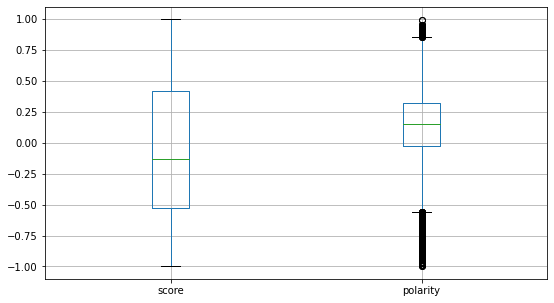

In [112]:
boxplot = df.boxplot(column=['score', 'polarity'], grid=True, figsize=(9, 5))

Funções auxiliares

In [113]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [114]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [115]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [116]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimentos por dia - Vader x SenticNet

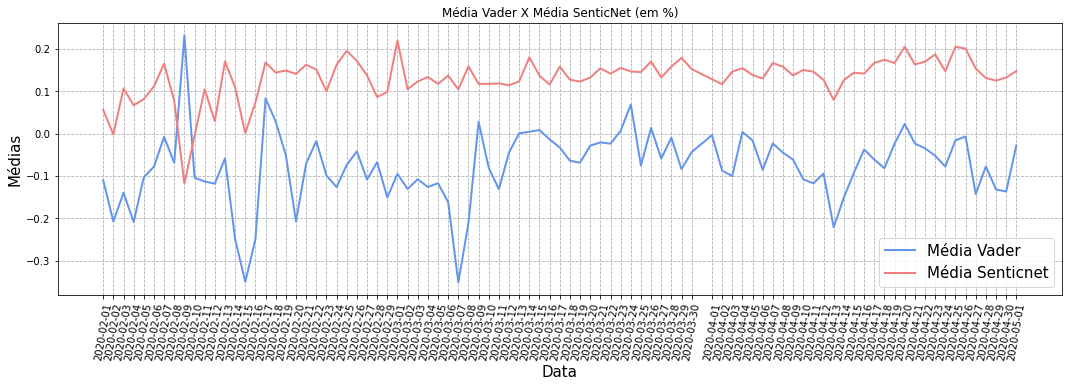

In [119]:
df1 = building_dates_df(df, 'score')
df2 = building_dates_df(df, 'polarity')

x = df1.created_at
y1 = df1.score_mean
y2 = df2.polarity_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet (em %)'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Trabalhando com faixa de valores de sentimentos

- -1,00 <= x => -0,33 (Negativa: -1,0)
- -0,33 < x => 0,33 (Neutra: 0)
- 0,33 < x => 1,00 (Positiva: 1,0)

In [245]:
def calc_zone(n):
    if (n <= -0.25):
        return -1
    elif (n <= 0.25):
        return 0
    else:
        return 1

In [246]:
score_zone = []
polarity_zone = []

for i, row in df.iterrows():
    score_zone.append(calc_zone(row.score))
    polarity_zone.append(calc_zone(row.polarity))
    


In [247]:
score_zone_series = pd.Series(score_zone)
polarity_zone_series = pd.Series(polarity_zone)

df['score_zone'] = score_zone_series
df['polarity_zone'] = polarity_zone_series

df.head(3)

,created_at,geo_source,state,city,text,score,lang,polarity,score_zone,polarity_zone
0,2020-02-01 01:07:58,user_location,Rio de Janeiro,Rio de Janeiro,RT @ChinaDaily: #Update: The number of confirm...,0.3818,en,0.162000,1,0
1,2020-02-01 02:34:28,user_location,Rio de Janeiro,Rio de Janeiro,RT @ScottGottliebMD: New numbers on the contin...,-0.4588,en,0.213286,-1,0
2,2020-02-01 04:56:21,user_location,Rio de Janeiro,Rio de Janeiro,RT @businessinsider: The real number of corona...,0.0772,en,0.256000,0,1


Média de sentimentos por dia - Vader x SenticNet - Faixas de Valores

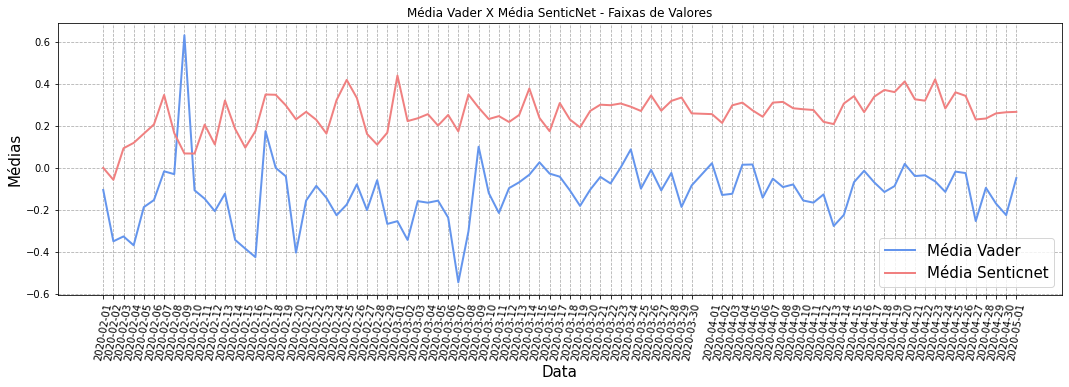

In [248]:
df1 = building_dates_df(df, 'score_zone')
df2 = building_dates_df(df, 'polarity_zone')

x = df1.created_at
y1 = df1.score_zone_mean
y2 = df2.polarity_zone_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet - Faixas de Valores'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Análises por período

In [5]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [6]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "Rio de Janeiro"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

,index,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,25,Rio de Janeiro,2020-03-06,1,0.01482,0.0,0,RJ,1,0
1,34,Rio de Janeiro,2020-03-07,1,0.01482,0.0,0,RJ,0,0
2,47,Rio de Janeiro,2020-03-08,2,0.02964,0.0,0,RJ,1,0
3,62,Rio de Janeiro,2020-03-09,2,0.02964,0.0,0,RJ,0,0
4,77,Rio de Janeiro,2020-03-10,2,0.02964,0.0,0,RJ,0,0


In [7]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-06


In [8]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-03-23


Datas relevantes:

- Data do primeiro caso: 06/03/2020
- Data da primeira morte: 23/03/2020


- Data do primeiro decreto de medidas restritivas (Governador): 17/03/2020
- Data da primeira renovação do decreto (Governador): 30/03/2020
- Data da segunda renovação do decreto (Governador): 13/04/2020
- Data da terceira renovação do decreto (Governador): 30/04/2020

**Análises - Datas de medidas restritivas - Antes e Depois a Primeira Medida**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 16/03/2020)**

In [268]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df1_periodo1)

18395

**Média de sentimentos no segundo intervalo (17/03/2020 a 30/04/2020)**

In [269]:
df1_periodo2 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-04-30 23:59:59"')
len(df1_periodo2)

62437

Gráfico - Média Valores

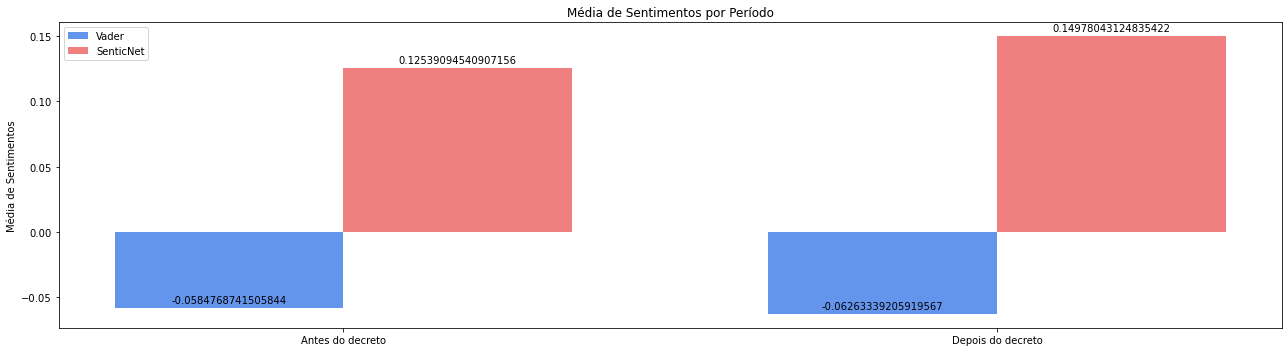

In [270]:
labels = ['Antes do decreto', 'Depois do decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Gráfico - Média Valores - Faixas

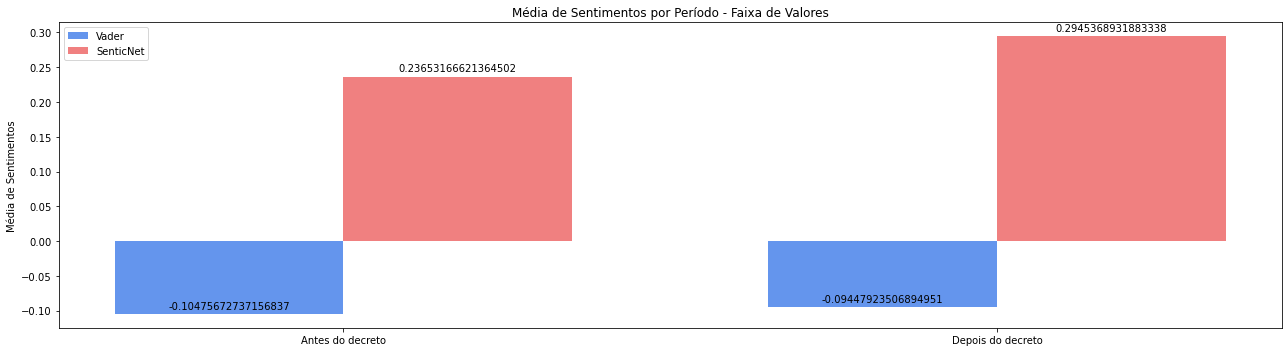

In [271]:
labels = ['Antes do decreto', 'Depois do decreto']
y1 = [mean(df1_periodo1['score_zone']), mean(df1_periodo2['score_zone'])]
y2 = [mean(df1_periodo1['polarity_zone']), mean(df1_periodo2['polarity_zone'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período - Faixa de Valores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Datas de medidas restritivas - Por períodos de decretos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 16/03/2020)**

In [272]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df1_periodo1)

18395

**Média de sentimentos no segundo intervalo (17/03/2020 a 29/03/2020)**

In [273]:
df1_periodo2 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-03-29 23:59:59"')
len(df1_periodo2)

16913

**Média de sentimentos no terceiro intervalo (30/03/2020 a 12/04/2020)**

In [274]:
df1_periodo3 = df.query('created_at >= "2020-03-30 00:00:00" and created_at <= "2020-04-12 23:59:59"')
len(df1_periodo3)

15045

**Média de sentimentos no quarto intervalo (13/04/2020 a 30/04/2020)**

In [275]:
df1_periodo4 = df.query('created_at >= "2020-04-13 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo4)

32085

Gráfico - Média Valores

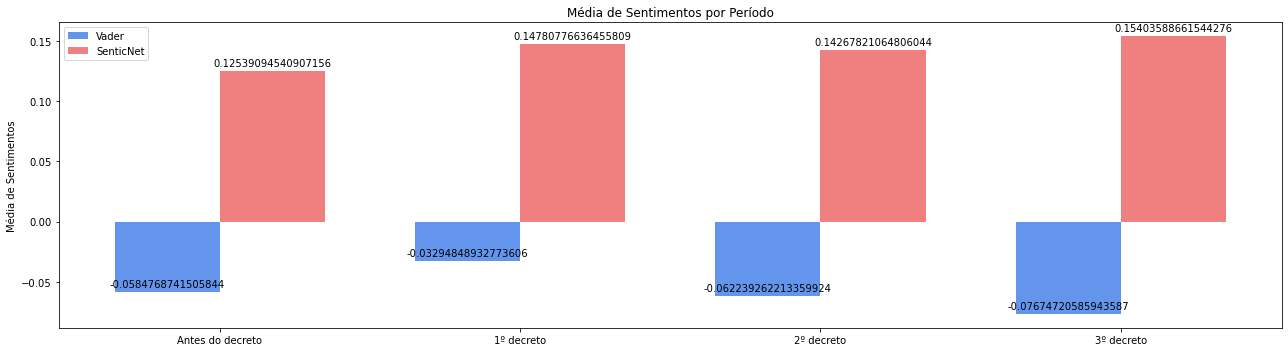

In [276]:
labels = ['Antes do decreto', '1º decreto', '2º decreto', '3º decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score']), mean(df1_periodo3['score']), mean(df1_periodo4['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity']), mean(df1_periodo3['polarity']), mean(df1_periodo4['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Gráfico - Média Valores - Faixas

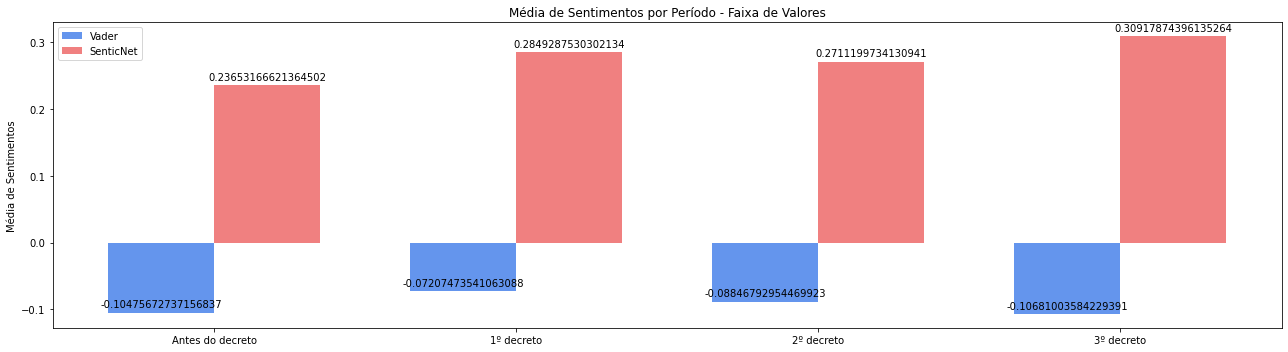

In [277]:
labels = ['Antes do decreto', '1º decreto', '2º decreto', '3º decreto']
y1 = [mean(df1_periodo1['score_zone']), mean(df1_periodo2['score_zone']), mean(df1_periodo3['score_zone']), mean(df1_periodo4['score_zone'])]
y2 = [mean(df1_periodo1['polarity_zone']), mean(df1_periodo2['polarity_zone']), mean(df1_periodo3['polarity_zone']), mean(df1_periodo4['polarity_zone'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período - Faixa de Valores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Marcos relevantes de casos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 05/03/2020)**

In [278]:
df2_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-05 23:59:59"')
len(df2_periodo1)

7162

**Média de sentimentos no segundo intervalo (06/02/2020 a 22/03/2020)**

In [279]:
df2_periodo2 = df.query('created_at >= "2020-02-06 00:00:00" and created_at <= "2020-03-22 23:59:59"')
len(df2_periodo2)

27136

**Média de sentimentos no terceiro intervalo (23/03/2020 a 01/05/2020)**

In [280]:
df2_periodo3 = df.query('created_at >= "2020-03-23 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df2_periodo3)

54684

Gráfico

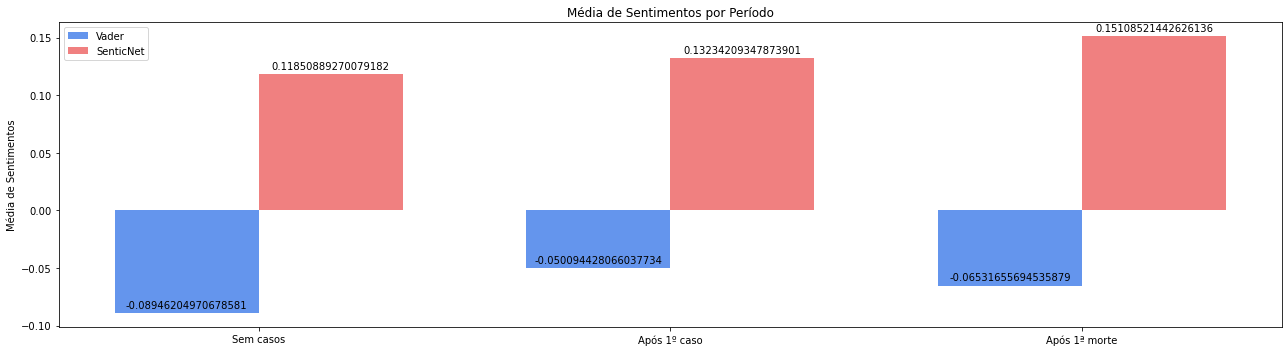

In [281]:
labels = ['Sem casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df2_periodo1['score']), mean(df2_periodo2['score']), mean(df2_periodo3['score'])]
y2 = [mean(df2_periodo1['polarity']), mean(df2_periodo2['polarity']), mean(df2_periodo3['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Gráfico - Faixas de Valores

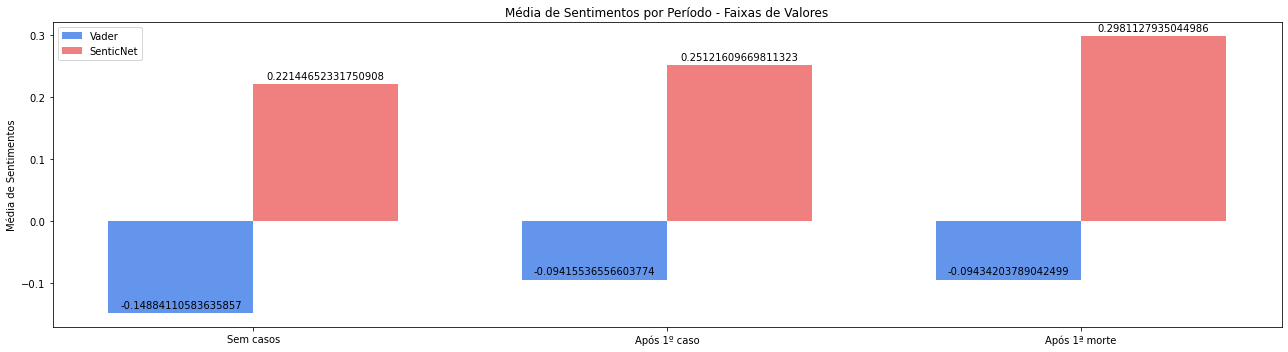

In [282]:
labels = ['Sem casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df2_periodo1['score_zone']), mean(df2_periodo2['score_zone']), mean(df2_periodo3['score_zone'])]
y2 = [mean(df2_periodo1['polarity_zone']), mean(df2_periodo2['polarity_zone']), mean(df2_periodo3['polarity_zone'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período - Faixas de Valores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Fontes:
- Confira as medidas do decreto do governo do RJ para conter o coronavírus - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/17/confira-as-medidas-do-decreto-do-governo-do-rj-para-conter-o-coronavirus.ghtml
- Witzel renova medidas restritivas contra o coronavírus no RJ por mais 15 dias - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/30/witzel-assina-decreto-nesta-segunda-renovando-medidas-restritivas-contra-o-coronavirus-no-rj-por-mais-15-dias.ghtml
- Coronavírus: Witzel prorroga até 30 de abril medidas restritivas no Rio: https://valorinveste.globo.com/mercados/brasil-e-politica/noticia/2020/04/13/coronavrus-witzel-prorroga-at-30-de-abril-medidas-restritivas-no-rio.ghtml